In [1]:
#[Hopefully final copy of LSTM code with sliding_window on CMU dataset]

In [2]:
# All Includes
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [6]:
def sliding_window(data, window_size, overlap):
    
    """
    given data for a single subactivity [Eg: Pour Milk] (for a given person/activity etc)
    reorganise it into sliding windows of given overlap. residual at the end is ignored
    
    outputs: expets and returns numpy arrays
    """
    num_samples = data.shape[0]
    
    if num_samples < window_size:
        print(" Not enough samples for sliding window", num_samples, window_size)
        return []
    
    overlap = 100 - overlap
    counter = int(overlap*window_size/100)
    if counter<=0:
        print("Error in Sliding window")
    
#     output = pd.DataFrame()
    output= []
    for i in range(0, num_samples-window_size+1, counter):
        curr_win = data[i:i+window_size]
#         output = output.append(curr_win)
        output.append(curr_win)
    output = np.array(output)
    return output

In [7]:
def get_data_person(path, window_size, overlap_percent):
    
    """
    get data for a current person/activity/sensor
    sliding window is applied to get fixed timesteps
    """
    
    data = pd.read_csv(path)
    group_indices = [(data["Coarse Label"] != data["Coarse Label"].shift()).cumsum()]
    
    grouped_data = []
    labels = []
    for key, group in data.groupby(group_indices, sort = False):
        curr_data = group[['Accel_X', 'Accel_Y', 'Accel_Z', 'Roll', 'Pitch', 'Yaw', 'Mag_X','Mag_Y', 'Mag_Z']]
        curr_label = group["Coarse Label"].iloc[0]
        
        curr_data_windows = sliding_window(curr_data.to_numpy(), window_size, overlap_percent)
        if len(curr_data_windows)!=0:
            num_windows = curr_data_windows.shape[0]
            curr_labels = [curr_label]*num_windows

            grouped_data.extend(curr_data_windows)
            labels.extend(curr_labels)
    grouped_data=np.array(grouped_data)
    labels = np.array(labels)
    print(data.shape, grouped_data.shape, labels.shape)
    return grouped_data, labels

In [8]:
# test_file = r"C:\Users\dcsang\PycharmProjects\embedding\cmu-kitchen-capture\imu_labelled\Brownie\S07_Brownie_IMU\2795.csv"
# blah = get_data_person(test_file, 128, 50)

In [9]:
def get_partition2(root, activities, persons_exclude, persons_test, window_size, overlap_percent, sensor_name, typ):
    
    data, labels = [], []
    for activity in activities:
        for person in os.listdir(os.path.join(root, activity)):
            curr_person = person.split("_")[0]
            if ((typ=="test" and curr_person in persons_test) or (typ=="train" and curr_person not in persons_test )):
                if curr_person not in persons_exclude:
                    
                    path = os.path.join(root, activity, curr_person+"_"+activity+"_IMU", sensor_name+".csv")
                    if os.path.exists(path):
                        curr_person_data, curr_person_labels = get_data_person(path, window_size, overlap_percent)
                        data.extend(curr_person_data)
                        labels.extend(curr_person_labels)
    data = np.array(data)
    labels = np.array(labels)
    return data,labels

In [10]:
def prepare(root, activities, persons_exclude, persons_test, sliding_window_size,overlap_percent, sensor_name):
    """
    1.combine subjects/activities together to prepare train/test set
    2. data organsied with sliding windows
    3. 
    """
    X_train, Y_train = get_partition2(root, activities, persons_exclude, persons_test, sliding_window_size,overlap_percent, sensor_name, "train")
    X_test, Y_test = get_partition2(root, activities, persons_exclude, persons_test, sliding_window_size,overlap_percent, sensor_name, "test")
    
    unique_labels = list(set(list(Y_train)+list(Y_test)))
    stoi , itos = {}, {}
    for idx,ul in enumerate(unique_labels):
        stoi[ul] =idx
        itos[idx]=ul
    
    squarer = lambda t: stoi[t]
    vfunc = np.vectorize(squarer)
    Y_train, Y_test = vfunc(Y_train), vfunc(Y_test)
    
    print("Train: ", X_train.shape, "Test: ", X_test.shape)
    return X_train, Y_train, X_test, Y_test, stoi, itos

In [11]:
root = r"C:\Users\dcsang\PycharmProjects\ActivityRecognitionIMU\data\imu_labelled"
activities = os.listdir(root)
# persons_test = ["S07", "S08", "S09", "S12"]
persons_test = ["S07", "S28", "S50", "S15" ]
# persons_exclude = ["S22", "S36", "S37", "S41"]
persons_exclude = []
sliding_win_size = 1024
overlap_percent = 50
# sensor_name = ["2794", "2795", "2796", "3261", "3337"]
sensor_name = "2796"
# sensor_name = ["2794", "2795", "2796", "3261", "3337", "0006660160E3", "000666015711", "000666015715", "000666015735"]

X_train,y_train, X_test, y_test, stoi, itos = prepare(root, activities, persons_exclude, persons_test, sliding_win_size, overlap_percent, sensor_name)
LABELS = list(stoi.keys())
print("Labels Count: ", len(LABELS))

 Not enough samples for sliding window 892 1024
 Not enough samples for sliding window 509 1024
 Not enough samples for sliding window 493 1024
 Not enough samples for sliding window 978 1024
(37121, 15) (51, 1024, 9) (51,)
 Not enough samples for sliding window 820 1024
 Not enough samples for sliding window 997 1024
 Not enough samples for sliding window 849 1024
 Not enough samples for sliding window 961 1024
(53087, 15) (82, 1024, 9) (82,)
 Not enough samples for sliding window 555 1024
 Not enough samples for sliding window 667 1024
 Not enough samples for sliding window 836 1024
 Not enough samples for sliding window 838 1024
(62730, 15) (101, 1024, 9) (101,)
 Not enough samples for sliding window 320 1024
 Not enough samples for sliding window 860 1024
(83453, 15) (141, 1024, 9) (141,)
 Not enough samples for sliding window 990 1024
(48388, 15) (80, 1024, 9) (80,)
 Not enough samples for sliding window 787 1024
 Not enough samples for sliding window 461 1024
 Not enough samples 

 Not enough samples for sliding window 883 1024
 Not enough samples for sliding window 906 1024
 Not enough samples for sliding window 866 1024
 Not enough samples for sliding window 555 1024
(17822, 15) (24, 1024, 9) (24,)
 Not enough samples for sliding window 755 1024
(25546, 15) (40, 1024, 9) (40,)
 Not enough samples for sliding window 633 1024
 Not enough samples for sliding window 465 1024
(16008, 15) (23, 1024, 9) (23,)
 Not enough samples for sliding window 886 1024
 Not enough samples for sliding window 929 1024
 Not enough samples for sliding window 424 1024
(13704, 15) (17, 1024, 9) (17,)
(19752, 15) (32, 1024, 9) (32,)
 Not enough samples for sliding window 684 1024
 Not enough samples for sliding window 601 1024
 Not enough samples for sliding window 444 1024
 Not enough samples for sliding window 853 1024
(16695, 15) (22, 1024, 9) (22,)
(15848, 15) (20, 1024, 9) (20,)
 Not enough samples for sliding window 711 1024
 Not enough samples for sliding window 930 1024
 Not eno

In [12]:
# Input Data 

training_data_count = len(X_train)  
test_data_count = len(X_test)  
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0]) 


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = len(LABELS) # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(3331, 1024, 9) (3331,) (573, 1024, 9) (573,) 0.12041195996226312 0.41644116174323426
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [13]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [14]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will al

In [15]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Device mapping:

Training iter #1500:   Batch Loss = 6.171104, Accuracy = 0.006000000052154064
PERFORMANCE ON TEST SET: Batch Loss = 6.2095255851745605, Accuracy = 0.06806282699108124
Training iter #30000:   Batch Loss = 4.878273, Accuracy = 0.09666666388511658
PERFORMANCE ON TEST SET: Batch Loss = 4.957504749298096, Accuracy = 0.11343804746866226
Training iter #60000:   Batch Loss = 4.675242, Accuracy = 0.14133332669734955
PERFORMANCE ON TEST SET: Batch Loss = 4.824527740478516, Accuracy = 0.11692844331264496
Training iter #90000:   Batch Loss = 4.522827, Accuracy = 0.14800000190734863
PERFORMANCE ON TEST SET: Batch Loss = 4.731962203979492, Accuracy = 0.12041884660720825
Training iter #120000:   Batch Loss = 4.335984, Accuracy = 0.19466666877269745
PERFORMANCE ON TEST SET: Batch Loss = 4.659796714782715, Accuracy = 0.12390924990177155
Training iter #150000:   Batch Loss = 4.133840, Accuracy = 0.2226666659116745
PERFORMANCE ON TEST SET: Batch Loss = 4.588672161102295, Accuracy = 0.151

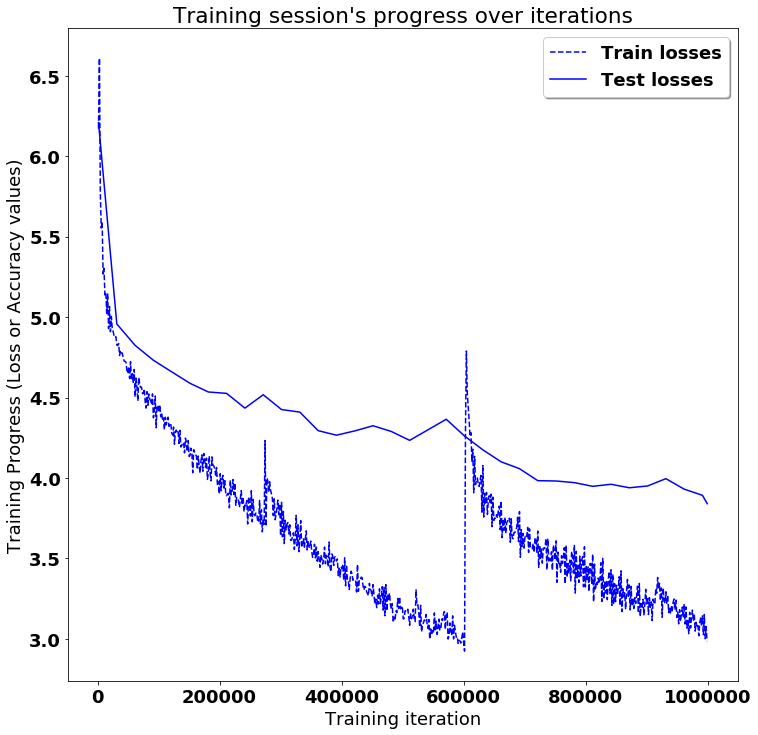

In [20]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
# plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
# plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

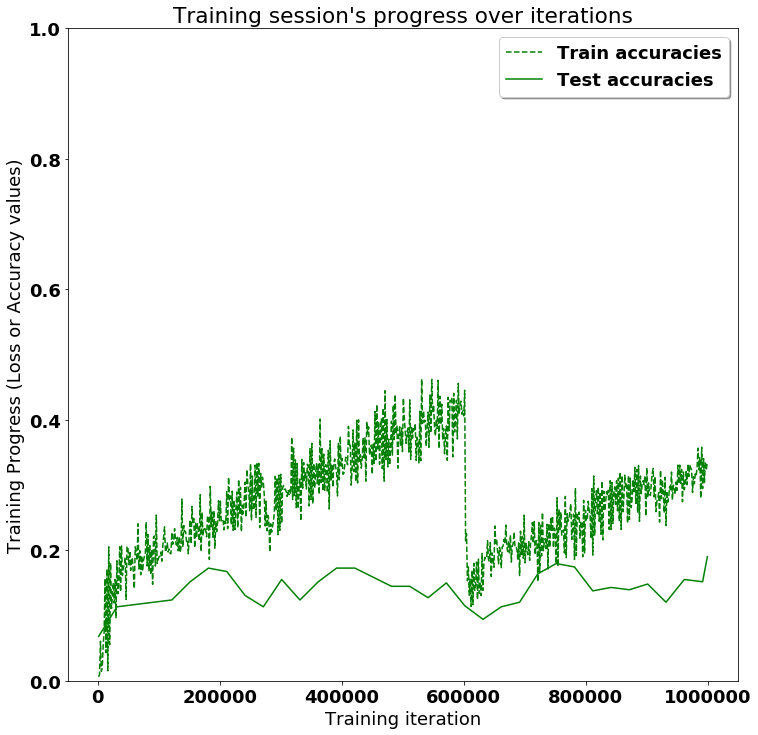

In [22]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
# plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
# plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0,1])
plt.show()

Testing Accuracy: 19.022688269615173%

Precision: 12.489093978304433%
Recall: 19.022687609075042%
f1_score: 12.402272881034133%

Confusion Matrix:
[[ 0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1  0  0  0  0  2  1  1  0  0  0  0  0  0  1  0  0  0  1  0  0  0
   0  0 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  1  0
   0  0  4]
 [ 0  0  0  0  0  1  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   2  0  0]
 [ 0  0  0  0  1  0  0  0  0  8  0  1  0  0  0  0  0  0  0  0  0  0  2  0
   3  0 38]
 [ 0  0  1  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 10]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0
   0  0  0]
 [ 0  0  0  0  0  0  0 34  0  2  0  0  0  0  0  0  3  0  0  0  0  0  0  0
   0  0 10]
 [ 0  0  0  0  0  0  0  1  0  0  0  4  0  1  0  0 12  1  0  0  0  0  0  0
   0  0 21]
 [ 0  0  0  0  0  0  0 22  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0 

C:\Users\dcsang\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dcsang\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


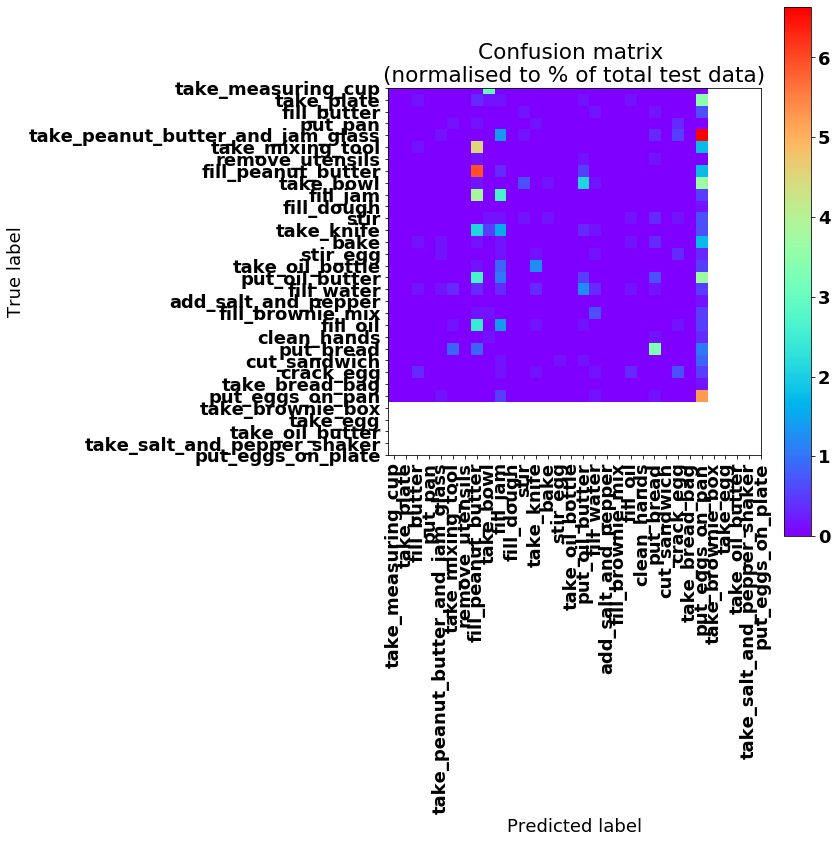

In [17]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
sess.close()